In [410]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from copy import copy, deepcopy

warnings.filterwarnings("ignore")

import mne
from mne import make_fixed_length_epochs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids, get_bids_path_from_fname
import autoreject
from autoreject import AutoReject, read_auto_reject

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.features import spike_feature_vector
from episcalp.io.read import load_persyst_spikes, load_reject_log
from episcalp.scripts.spikes.summary import _get_spike_annots
from episcalp.cross_validate import (
    get_X_features,
    load_derived_datasets,
    _compute_spike_rates,
)
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder

# if you installed sporf via README
#from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Functions

In [411]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 0,
        "epilepsy-abnormal-eeg": 1,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

In [412]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [413]:
def _preprocess_epochs_tfr(data):
    """Turn TFR data into a 2D array."""
    assert data.ndim == 4

    # take the average over frequencies
    data = np.mean(data, axis=2)

    # move the epoch ("window") axis to last
    data = np.moveaxis(data, 0, -2)

    # compress the time axis
    data = np.mean(data, axis=-1)

    # convert to dB
    data = 20 * np.log10(data)

    data = np.reshape(data, (data.shape[0], -1))
    return data

In [414]:
def _load_subject_derivs(deriv_path, read_func, subjects=None, search_str="*.npy"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)

    this_path = deriv_path
    while this_path.parent.name != "derivatives" and this_path.parent.name != "/":
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            deriv = read_func(fpath, source_check=False)

            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.get_data()

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)
            dataset["roots"].append(root)

    return dataset

In [415]:
def _load_subject_tfrs(deriv_path, read_func, subjects=None, search_str="*.h5"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)

    this_path = deriv_path
    while this_path.parent.name != "derivatives" and this_path.parent.name != "/":
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            try:
                deriv = read_func(fpath)[0]
            except Exception as e:
                print(f"Failed trying to load {fpath}.")
                raise Exception(e)
            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.data

            # apply mean across axis 2
            deriv_data = _preprocess_epochs_tfr(deriv_data)
            #             deriv_data = np.mean(deriv_data, axis=2)

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)
            dataset["roots"].append(root)

    return dataset

# Define Data Directories

In [416]:
user = "patrick"
if user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [417]:
jh_ica_root = jhroot / "derivatives" / "ICA" / "1-30Hz-30" / "win-20"
jeff_ica_root = jeffroot / "derivatives" / "ICA" / "1-30Hz-30" / "win-20"

In [418]:
reference = "monopolar"
radius = "1.25"
winsize = "500"
stepsize = "250"

# define derivative chains
ss_deriv_chain = Path("sourcesink") /  f"win-{winsize}" / f"step-{stepsize}" / reference
frag_deriv_chain = Path("fragility") / f"radius{radius}" / f"win-{winsize}" / f"step-{stepsize}" / reference

delta_tfr_deriv_chain = Path("tfr") / "delta"
theta_tfr_deriv_chain = Path("tfr") / "theta"
alpha_tfr_deriv_chain = Path("tfr") / "alpha"
beta_tfr_deriv_chain = Path("tfr") / "beta"

In [419]:
if user == "adam":
    root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/")
elif user == "patrick":
    root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
deriv_root = root / "derivatives"
figure_dir = deriv_root
source_root = root / "sourcedata"

# Load in Spikes with Autoreject

In [420]:
# read in spike dataframe
jh_spike_dataset = load_persyst_spikes(jhroot)
jeff_spike_dataset = load_persyst_spikes(jeffroot)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff20

In [421]:
def get_bad_spike_epochs(dataset, deriv_root, verbose=False):
    subjects = dataset["subject"]

    # loop through each dataset and preprocess the channel spike
    # dataframes based on the autoreject log
    for idx in range(len(subjects)):
        subject = subjects[idx]

        # get the channel spike df and bids path
        data = dataset["data"][idx]
        bids_path = dataset["bids_path"][idx]
        bids_path.update(root=deriv_root)

        if data.empty:
            if verbose:
                print(f"Skipping: {subject} with {bids_path}")
            continue

        # load in the reject log
        raw = read_raw_bids(bids_path)
        reject_log = load_reject_log(bids_path)

        # get spikes not in bad epochs
        bad_epochs = reject_log.bad_epochs
        bad_epoch_idx = np.argwhere(bad_epochs)
        n_secs = data["n_secs"][0]
        events = mne.make_fixed_length_events(
            raw, id=1, start=0, stop=None, duration=1.0, first_samp=True, overlap=0.0
        )
        assert len(events) == len(bad_epochs)

        # mark all spikes in bad epochs
        data["epoch_idx"] = None
        data["bad_epoch"] = None

        for jdx, sample in enumerate(data["sample"]):
            lower_idx = np.argwhere(sample <= events[:, 0])[0]
            higher_idx = np.argwhere(sample >= events[:, 0])[-1]
            epoch_idx = higher_idx[0]
            data["epoch_idx"][jdx] = epoch_idx
            in_bad_epoch = epoch_idx in bad_epoch_idx
            data["bad_epoch"][jdx] = in_bad_epoch

        # reset the new dataframe
        dataset["data"][idx] = data
    return dataset

In [422]:
jh_spike_dataset = get_bad_spike_epochs(jh_spike_dataset, jh_ica_root)
jeff_spike_dataset = get_bad_spike_epochs(jeff_spike_dataset, jeff_ica_root)
spike_dataset = deepcopy(jh_spike_dataset)
for key, item in jeff_spike_dataset.items():
    spike_dataset[key].extend(deepcopy(item))

# Load in Other Features (Once)

In [423]:
roots = [jhroot, jeffroot]
deriv_chains = [frag_deriv_chain, frag_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = "*desc-perturbmatrix*.npy"

# load fragility dataset
fragility_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)
X_fragility = get_X_features(fragility_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-2

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh007\sub-jhh007_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh007', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh008\sub-jhh008_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh008', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh009\sub-jhh009_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh009', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh014\sub-jhh014_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh014', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh015\sub-jhh015_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh015', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh016\sub-jhh016_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh016', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh023\sub-jhh023_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh023', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh024\sub-jhh024_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh024', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh025\sub-jhh025_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh025', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh101\sub-jhh101_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh101', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh102\sub-jhh102_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh102', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh103\sub-jhh103_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh103', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh115\sub-jhh115_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh115', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh116\sub-jhh116_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh116', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh117\sub-jhh117_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh117', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh124\sub-jhh124_task-asleep_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh124', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh124\sub-jhh124_task-awake_run-02_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh124', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh125', 'session': None, 'task': 'a

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh202\sub-jhh202_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh202', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh203\sub-jhh203_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh203', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh204\sub-jhh204_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh204', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh211\sub-jhh211_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh211', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh212\sub-jhh212_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh212', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh213\sub-jhh213_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh213', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh222\sub-jhh222_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh222', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh223\sub-jhh223_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh223', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh224\sub-jhh224_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh224', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff204', 'jeff205', 'jeff206', 'jeff207', 'jeff208', 'jeff209', 'jeff210']
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff001\sub-jeff001_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff001', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff001\sub-jeff001_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff001', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'reco

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-4_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None, 'run': '4', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff205', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff206\sub-jeff206_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff206', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff207\sub-jeff207_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff207', 'session': '1', 'task': None, 'acquisition': None

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

In [424]:
roots = [jhroot, jeffroot]
deriv_chains = [ss_deriv_chain, ss_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = "*desc-ssindmatrix*.npy"

# load fragility dataset
ss_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)
X_ss = get_X_features(ss_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopol

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh008\sub-jhh008_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh008', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh009\sub-jhh009_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh009', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh010\sub-jhh010_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh010', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh013\sub-jhh013_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh013', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh014\sub-jhh014_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh014', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh015\sub-jhh015_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh015', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh021\sub-jhh021_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh021', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh022\sub-jhh022_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh022', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh023\sub-jhh023_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh023', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh028\sub-jhh028_task-asleep_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh028', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh028\sub-jhh028_task-awake_run-02_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh028', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh029\sub-jhh029_task-awake_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh029', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '0

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh108\sub-jhh108_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh108', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh109\sub-jhh109_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh109', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh110\sub-jhh110_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh110', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh116\sub-jhh116_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh116', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh117\sub-jhh117_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh117', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh118\sub-jhh118_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh118', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh125', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh126\sub-jhh126_task-awake_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh126', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh127', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '0

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh206\sub-jhh206_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh206', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh207\sub-jhh207_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh207', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh208\sub-jhh208_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh208', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh216\sub-jhh216_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh216', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh217\sub-jhh217_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh217', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh218\sub-jhh218_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh218', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh224\sub-jhh224_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh224', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh225\sub-jhh225_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh225', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh226\sub-jhh226_run-01_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jhh226', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'reco

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff002\sub-jeff002_ses-1_run-1_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff002', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff101\sub-jeff101_ses-1_run-2_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff101', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff101\sub-jeff101_ses-1_run-4_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff101', 'session': '1', 'task': None, 'acquisition': None, 'run': '4', 'processing': None, 's

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-5_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '5', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 's

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None, 'run': '5', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff203', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff203\sub-jeff203_ses-1_run-3_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff203', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 's

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-1_run-1_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-1_run-2_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-1_run-3_desc-ssindmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 's

In [425]:
roots = [jhroot, jeffroot]
deriv_chains = [ss_deriv_chain, ss_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = "*desc-sinkindmatrix*.npy"

# load fragility dataset
sink_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)
X_sink = get_X_features(sink_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopol

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh009\sub-jhh009_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh009', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh010\sub-jhh010_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh010', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh011\sub-jhh011_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh011', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh015\sub-jhh015_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh015', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh016\sub-jhh016_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh016', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh017\sub-jhh017_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh017', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh022\sub-jhh022_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh022', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh023\sub-jhh023_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh023', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh024\sub-jhh024_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh024', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh030\sub-jhh030_task-awake_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh030', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh101\sub-jhh101_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh101', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh102\sub-jhh102_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh102', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh109\sub-jhh109_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh109', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh110\sub-jhh110_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh110', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh111\sub-jhh111_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh111', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh119\sub-jhh119_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh119', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh120\sub-jhh120_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh120', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh121\sub-jhh121_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh121', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh127', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh127\sub-jhh127_task-awake_run-02_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh127', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh128\sub-jhh128_task-awake_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh128', 'session': None, 'task': 'awake', 'acquisition': None, 'ru

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh208\sub-jhh208_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh208', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh209\sub-jhh209_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh209', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh210\sub-jhh210_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh210', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh218\sub-jhh218_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh218', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh219\sub-jhh219_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh219', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh220\sub-jhh220_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh220', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh228\sub-jhh228_task-asleep_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh228', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh228\sub-jhh228_task-awake_run-02_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh228', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh229\sub-jhh229_task-awake_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh229', 'session': None, 'task': 'awake', 'acquisition': None, 'ru

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': No

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-3_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-4_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '4', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-5_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '5', 'processing': No

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff203', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff203\sub-jeff203_ses-1_run-3_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff203', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff204\sub-jeff204_ses-1_run-1_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff204', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': No

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

In [426]:
roots = [jhroot, jeffroot]
deriv_chains = [delta_tfr_deriv_chain, delta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
delta_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)
X_delta = get_X_features(delta_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\delta
Loading data for subjects

In [427]:
roots = [jhroot, jeffroot]
deriv_chains = [theta_tfr_deriv_chain, theta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
theta_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

X_theta = get_X_features(theta_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\theta
Loading data for subjects

In [428]:
roots = [jhroot, jeffroot]
deriv_chains = [alpha_tfr_deriv_chain, alpha_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
alpha_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

X_alpha = get_X_features(alpha_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\alpha
Loading data for subjects

In [429]:
roots = [jhroot, jeffroot]
deriv_chains = [beta_tfr_deriv_chain, beta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
beta_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)
X_beta = get_X_features(beta_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\beta
Loading data for subjects:

In [430]:
feature_dict = {
    "fragility": X_fragility,
    "sourcesink": X_ss,
    "sink": X_sink,
    "delta": X_delta,
    "theta": X_theta,
    "alpha": X_alpha,
    "beta": X_beta,
}

In [431]:
subjects = np.array(fragility_dataset["subject"])
roots = fragility_dataset["roots"]

exp_conditions = []
for subject, root in zip(subjects, roots):
    subj_df = _get_exp_condition(subject, root)
    exp_condition = subj_df["exp_condition"].values[0]
    exp_conditions.append(exp_condition)

# Define run specific parameters

In [2272]:
# Features to use on top of spike features
features = ["alpha", "beta"]
feature_type = "lobes"
perception_thresh = 0.8
n_splits = 20
train_size = 0.7
random_state = 12345
clf_name = 'rf'

cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)


# Define input X and labels Y

In [2273]:
for idx in range(len(spike_dataset["subject"])):
    ch_spike_df = spike_dataset["data"][idx]

    if ch_spike_df.empty:
        continue

    # only keep rows with bad epochs
    ch_spike_df = ch_spike_df[ch_spike_df["bad_epoch"] == False]
    ch_spike_df["perception"] = pd.to_numeric(ch_spike_df["perception"])
    ch_spike_df = ch_spike_df[ch_spike_df["perception"] >= perception_thresh]
    spike_dataset["data"][idx] = ch_spike_df

spike_features = []
for idx in range(len(spike_dataset["subject"])):
    ch_spike_df = spike_dataset["data"][idx]
    ch_names = spike_dataset["ch_names"][idx]
    spike_feature_vec = spike_feature_vector(ch_spike_df, ch_names)
    spike_features.append(spike_feature_vec)

spike_features = np.array(spike_features)

In [2274]:
X = spike_features
for fdx, feat in enumerate(features):
    X = np.hstack(
        (
            X,
            feature_dict[feat]
        )
    )

In [2275]:
y = np.array(convert_experimental_cond_to_y(exp_conditions))
y_classes = ['normal-eeg', 'epilepsy-abnormal-eeg']

In [2276]:
print(f"X: {X.shape}")
print(f"Y: {y.shape}")

X: (125, 20)
Y: (125,)


# Define Classification Model

In [2277]:
max_features = X.shape[1]
rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
    #                    "penalty": "l2"
}

In [2278]:
if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)
    clf = make_pipeline(
        StandardScaler(),
        clf
    )

# Define Cross Validation Experiment

In [2279]:
scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": "roc_auc",  # roc_auc_score,
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

# define multiclass cross_validation scoring metrics
f1_micro = lambda x: make_scorer(f1_score, average="micro")
recall_micro = lambda x: make_scorer(recall_score, average="micro")
precision_micro = lambda x: make_scorer(precision_score, average="micro")
jaccard_micro = lambda x: make_scorer(jaccard_score, average="micro")
roc_ovr = lambda x: make_scorer(roc_auc_score, multi_class="ovr")

# some scorers need to get defined with this for multiclass
def cohen_scorer(clf, X, y):
    y_pred = clf.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return cohen_kappa_score(y, y_pred)


def balanced_accuracy_scorer(clf, X, y):
    y_pred = clf.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return balanced_accuracy_score(y, y_pred)


multiclass_scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_scorer,
    "cohen_kappa_score": cohen_scorer,
    "roc_auc_ovr": "roc_auc_ovr",  # roc_ovr,
    "f1_micro": "f1_micro",  # f1_micro,
    "recall_micro": "recall_micro",
    "precision_micro": "precision_micro",
    "jaccard_micro": "jaccard_micro",
}

if len(np.unique(y_classes)) == 2:
    scoring = scoring_funcs
else:
    scoring = multiclass_scoring_funcs

print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'jaccard': 'jaccard', 'average_precision': 'average_precision', 'neg_brier_score': 'neg_brier_score'}


In [2280]:
# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=subjects,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
    error_score="raise",
)

# get the estimators
estimators = scores.pop("estimator")

In [2281]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
    "test_y",
    "test_y_encodings",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_y"].append(y[test_inds])
    #     scores["test_y_encodings"].append(y_encode[test_inds])

    # evaluate on the train set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)
    y_pred_label = np.argmax(y_pred_prob, axis=1)

    # compute calibration curve
    if len(np.unique(y_classes)) == 2:
        if y_pred_prob.ndim == 2:
            y_pred_prob = y_pred_prob[:, -1]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_train, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["train_fraction_pos"].append(fraction_of_positives)
        scores["train_mean_pred_value"].append(mean_predicted_value)

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y_classes)) == 2:
        fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
        scores["train_fpr"].append(fpr)
        scores["train_tpr"].append(tpr)
        scores["train_fnr"].append(fnr)
        scores["train_tnr"].append(tnr)
        scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)
    y_pred_label = np.argmax(y_pred_prob, axis=1)

    # compute calibration curve
    if len(np.unique(y_classes)) == 2:
        if y_pred_prob.ndim == 2:
            y_pred_prob = y_pred_prob[:, -1]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["test_fraction_pos"].append(fraction_of_positives)
        scores["test_mean_pred_value"].append(mean_predicted_value)

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y_classes)) == 2:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
        scores["test_fpr"].append(fpr)
        scores["test_tpr"].append(tpr)
        scores["test_fnr"].append(fnr)
        scores["test_tnr"].append(tnr)
        scores["test_thresholds"].append(thresholds)

    if y_test.ndim == 2:
        y_test_ = y_test.astype(int).argmax(axis=1)
    else:
        y_test_ = y_test.astype(int)
    conf_matrix = confusion_matrix(y_test_, (y_pred_label).astype(int))
    if len(np.unique(y_classes)) == 2:
        tn, fp, fn, tp = conf_matrix.ravel()
        scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator,
        X_test,
        y_test,
        n_repeats=5,
        random_state=random_state,
        n_jobs=-1,
        scoring="roc_auc_ovr",
    )
    scores["test_importances"].append(r.importances)

Using estimator  RandomForestClassifier(max_features=20, n_estimators=1000, n_jobs=-1,
                       random_state=12345)
[1.00000000e-03 1.30000000e-02 2.80000000e-02 7.14000000e-02
 1.40400000e-01 2.31000000e-01 6.77000000e-01 7.71400000e-01
 9.21400000e-01 9.83400000e-01 1.00000001e+00]
[0.007      0.0313     0.0764     0.1061     0.1672     0.2835
 0.4386     0.7471     0.9278     0.9859     0.99900001]
[0.         0.0202     0.0446     0.1154     0.1582     0.235
 0.694      0.7498     0.8492     0.9638     0.99600001]
[0.004      0.0333     0.174      0.2963     0.3614     0.3895
 0.532      0.7832     0.7988     0.9285     0.98100001]
[0.002      0.028      0.0596     0.103      0.147      0.268
 0.6818     0.7882     0.85       0.9348     0.99300001]
[0.002      0.0898     0.2022     0.297      0.326      0.367
 0.4302     0.4913     0.6262     0.8012     0.97800001]
[0.         0.0362     0.0702     0.1164     0.167      0.249
 0.6604     0.769      0.834      0.9394  

In [2282]:
# add metadata
scores["y_classes"] = y_classes

In [2283]:
exp_name =  f"spikes-{perception_thresh}-" + "-".join(features) + "-" + feature_type
fname = (
    deriv_root.parent
    / "derivatives" / "experiments"
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_{exp_name}.json"
)
print(fname)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\experiments\cv20_rf_mtry20_spikes-0.8-alpha-beta-lobes.json


In [2284]:
with open(fname.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)

# Basic Model Plotting

In [2285]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN


In [2286]:
def _interp_roc(fpr, tpr):
    mean_fpr = np.linspace(0, 1, 100)

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return interp_tpr, mean_fpr

In [2287]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

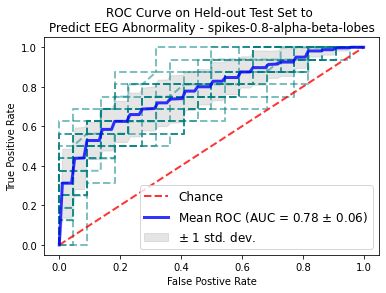

In [2288]:
which_set = "test"
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(figure_dir / "experiments" / "figures" / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")

In [2289]:
extra_str = "_micro"
extra_str = ""
roc_str = f"test_roc_auc_ovr"
roc_str = f"test_roc_auc"

metrics = [
    f"test_f1{extra_str}",
    f"test_recall{extra_str}",
    f"test_precision{extra_str}",
    roc_str,
    f"test_balanced_accuracy",
    f"test_cohen_kappa_score",
]

df = pd.DataFrame()
for metric in metrics:
    metric_scores = scores[metric]
    df[metric] = metric_scores

df = pd.melt(df, value_name="value", var_name="metric")

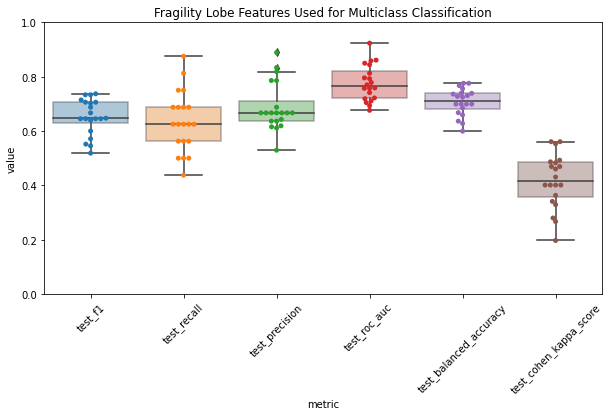

In [2290]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    x="metric",
    y="value",
    #     color="gray",
    data=df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="metric",
    y="value",
    #     hue="exp_condition",
    #               color="black",
    data=df,
    ax=ax,
)
ax.set(
    ylim=[0, 1],
    title="Fragility Lobe Features Used for Multiclass Classification",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# ax.axhline(0.5, label="chance")
fig.patch.set_facecolor("white")
fig.savefig(figure_dir / "experiments" / "figures" / f"metrics_{exp_name}.pdf", bbox_inches="tight")